In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import nfl_data_py as nfl
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance
import plotly

In [6]:
# Load play-by-play data
pbp = nfl.import_pbp_data([2023,2024], include_participation=False)

2023 done.
2024 done.
Downcasting floats.


In [7]:
pbp

,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,out_of_bounds,home_opening_kickoff,qb_epa,xyac_epa,xyac_mean_yardage,xyac_median_yardage,xyac_success,xyac_fd,xpass,pass_oe
0,1.0,2023_01_ARI_WAS,2023091007,WAS,ARI,REG,1,None,None,None,...,0.0,1.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,39.0,2023_01_ARI_WAS,2023091007,WAS,ARI,REG,1,WAS,home,ARI,...,0.0,1.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,55.0,2023_01_ARI_WAS,2023091007,WAS,ARI,REG,1,WAS,home,ARI,...,0.0,1.0,-0.336103,NaN,NaN,NaN,NaN,NaN,0.515058,-51.505844
3,77.0,2023_01_ARI_WAS,2023091007,WAS,ARI,REG,1,WAS,home,ARI,...,0.0,1.0,0.703308,0.340652,3.328642,1.0,0.996628,0.583928,0.661106,33.889408
4,102.0,2023_01_ARI_WAS,2023091007,WAS,ARI,REG,1,WAS,home,ARI,...,0.0,1.0,0.469799,NaN,NaN,NaN,NaN,NaN,0.196065,-19.606466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85840,4350.0,2024_14_SEA_ARI,2024120807,ARI,SEA,REG,14,ARI,home,SEA,...,0.0,1.0,0.446830,NaN,NaN,NaN,NaN,NaN,0.994749,0.525051
85841,4384.0,2024_14_SEA_ARI,2024120807,ARI,SEA,REG,14,ARI,home,SEA,...,0.0,1.0,-0.622971,NaN,NaN,NaN,NaN,NaN,0.993123,0.687653
85842,4419.0,2024_14_SEA_ARI,2024120807,ARI,SEA,REG,14,ARI,home,SEA,...,0.0,1.0,-0.677687,NaN,NaN,NaN,NaN,NaN,0.993178,0.682151
85843,4442.0,2024_14_SEA_ARI,2024120807,ARI,SEA,REG,14,ARI,home,SEA,...,0.0,1.0,-3.455225,NaN,NaN,NaN,NaN,NaN,0.990451,0.954854


In [8]:
# Find out when field goals happen
field_goal_attempts = (
    pbp.dropna(subset=['down', 'field_goal_attempt'])
    .groupby('down')['field_goal_attempt']
    .sum()
)
print(field_goal_attempts)

down
1.0      39.0
2.0      55.0
3.0      53.0
4.0    1834.0
Name: field_goal_attempt, dtype: float32


In [9]:
# Get data for field goals
field_goals = (
    pbp[pbp['field_goal_attempt'] == 1]
    .assign(field_goal_made=lambda x: np.where(x['field_goal_result'] == 'made', 1, 0))
    .loc[:, ['yardline_100', 'half_seconds_remaining', 'goal_to_go', 'score_differential', 
             'roof', 'surface', 'temp', 'wind', 'field_goal_made', 'kicker_player_name']]
)

In [10]:
# Check NA values
na_counts = field_goals.isna().sum()
print("NA Counts:")
print(na_counts)

# Remove rows with NA in 'roof'
field_goals = field_goals.dropna(subset=['roof'])

# Check where NA values for temp and wind come from
temp_na_by_roof = field_goals[field_goals['temp'].isna()].groupby('roof').size()
wind_na_by_roof = field_goals[field_goals['wind'].isna()].groupby('roof').size()
print("NA in temp grouped by roof:")
print(temp_na_by_roof)
print("NA in wind grouped by roof:")
print(wind_na_by_roof)

NA Counts:
yardline_100                0
half_seconds_remaining      0
goal_to_go                  0
score_differential          0
roof                        0
surface                     0
temp                      832
wind                      832
field_goal_made             0
kicker_player_name          0
dtype: int64
NA in temp grouped by roof:
roof
closed      271
dome        360
open         61
outdoors    140
dtype: int64
NA in wind grouped by roof:
roof
closed      271
dome        360
open         61
outdoors    140
dtype: int64


In [11]:
# Fill NA values for temp and wind
field_goals['temp'] = field_goals['temp'].fillna(68)
field_goals['wind'] = field_goals['wind'].fillna(0)

In [12]:
# Check data types
print(field_goals.dtypes)

yardline_100              float32
half_seconds_remaining    float32
goal_to_go                  int32
score_differential        float32
roof                       object
surface                    object
temp                      float32
wind                      float32
field_goal_made             int64
kicker_player_name         object
dtype: object


In [13]:
# Convert 'goal_to_go' to categorical
field_goals['goal_to_go'] = field_goals['goal_to_go'].astype('category')

In [14]:
# Prepare data for modeling
X = field_goals[['yardline_100', 'half_seconds_remaining', 'score_differential', 
                 'roof', 'surface', 'temp', 'wind']]
y = field_goals['field_goal_made']

In [15]:
# One-hot encoding for categorical variables
X = pd.get_dummies(X, drop_first=True)

In [17]:
# Build the Random Forest model
rf = RandomForestClassifier(random_state=86)
rf.fit(X, y)


RandomForestClassifier(random_state=86)

In [18]:
# Check the Random Forest model
print("Random Forest Model:")
print(rf)

Random Forest Model:
RandomForestClassifier(random_state=86)


In [19]:
# Feature importance
importances = rf.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

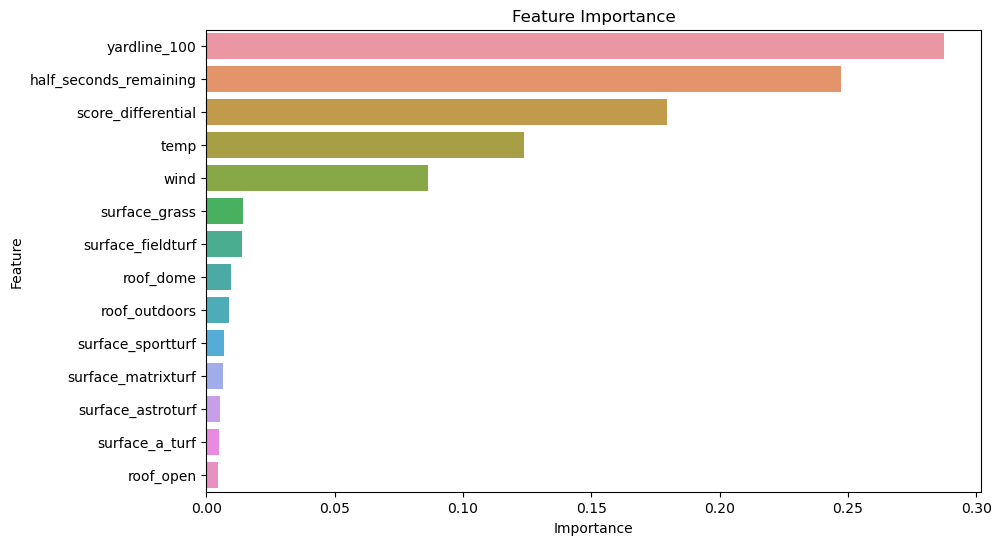

In [20]:
# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df, x='Importance', y='Feature')
plt.title('Feature Importance')
plt.show()

In [21]:
# Get predictions
field_goals['pred_prob'] = rf.predict_proba(X)[:, 1]


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


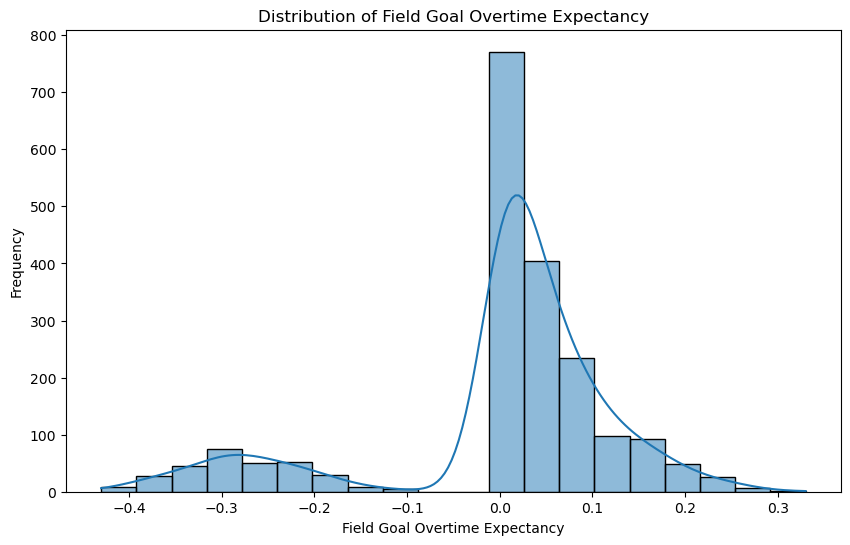

In [23]:
# Combine predictions with original dataset
field_goals['fg_oe'] = field_goals['field_goal_made'] - field_goals['pred_prob']

# Plot the distribution of fg_oe
plt.figure(figsize=(10, 6))
sns.histplot(field_goals['fg_oe'], bins=20, kde=True)
plt.title('Distribution of Field Goal Over Expectancy')
plt.xlabel('Field Goal Overtime Expectancy')
plt.ylabel('Frequency')
plt.show()


In [27]:
# See leaderboard
leaderboard = (
    field_goals.groupby('kicker_player_name')
    .agg(kicks_oe_made=('fg_oe', 'sum'), attempts=('field_goal_made', 'count'))
    .reset_index()
    .sort_values(by='kicks_oe_made', ascending=False)
)

In [28]:
print("Leaderboard:")
print(leaderboard)

Leaderboard:
   kicker_player_name  kicks_oe_made  attempts
7           C.Boswell   2.330000e+00        71
8            C.Dicker   1.920000e+00        63
43             N.Folk   1.810000e+00        52
22           H.Butker   1.590000e+00        66
10       C.McLaughlin   1.380000e+00        59
2            B.Aubrey   9.800000e-01        73
48             W.Lutz   9.300000e-01        63
12           C.Santos   9.000000e-01        58
31          J.Sanders   8.800000e-01        58
23            J.Bates   7.800000e-01        22
29            J.Myers   6.100000e-01        65
34        K.Fairbairn   5.400000e-01        68
9            C.Little   4.600000e-01        20
49         W.Reichard   3.900000e-01        17
40           M.Prater   3.700000e-01        39
18          E.Pineiro   2.400000e-01        52
42           M.Wright   2.200000e-01        13
30             J.Romo   2.100000e-01        12
46          S.Shrader   1.800000e-01         5
24          J.Elliott   1.500000e-01        57


In [24]:
# See leaderboard
leaderboard = (
    field_goals.groupby('kicker_player_name')['fg_oe']
    .sum()
    .reset_index()
    .rename(columns={'fg_oe': 'kicks_oe_made'})
    .sort_values(by='kicks_oe_made', ascending=False)
)

In [26]:
print("Leaderboard:")
print(leaderboard)

Leaderboard:
   kicker_player_name  kicks_oe_made
7           C.Boswell   2.330000e+00
8            C.Dicker   1.920000e+00
43             N.Folk   1.810000e+00
22           H.Butker   1.590000e+00
10       C.McLaughlin   1.380000e+00
2            B.Aubrey   9.800000e-01
48             W.Lutz   9.300000e-01
12           C.Santos   9.000000e-01
31          J.Sanders   8.800000e-01
23            J.Bates   7.800000e-01
29            J.Myers   6.100000e-01
34        K.Fairbairn   5.400000e-01
9            C.Little   4.600000e-01
49         W.Reichard   3.900000e-01
40           M.Prater   3.700000e-01
18          E.Pineiro   2.400000e-01
42           M.Wright   2.200000e-01
30             J.Romo   2.100000e-01
46          S.Shrader   1.800000e-01
24          J.Elliott   1.500000e-01
37          M.Badgley   1.200000e-01
44          R.Bullock   7.000000e-02
25           J.Gillan   2.000000e-02
1           A.Seibert   1.000000e-02
16       D.Ogunbowale   1.000000e-02
21         G.Zuerlein   5

In [33]:
import plotly.express as px

# Create interactive scatter plot
fig = px.scatter(
    leaderboard, 
    x='attempts', 
    y='kicks_oe_made', 
    color='kicker_player_name',
    hover_name='kicker_player_name',
    title='Scatter Plot of Attempts vs Field Goal Over Expected (FG OE)',
    labels={
        'attempts': 'Attempts',
        'kicks_oe_made': 'Field Goal Over Expected (FG OE)'
    },
    size_max=15,
    template='plotly_white'
)

# Update layout for better aesthetics
fig.update_layout(
    title={
        'x':0.5,
        'xanchor': 'center'
    },
    legend_title_text='Kicker Player Name'
)

fig.show()